<a href="https://colab.research.google.com/github/chang-heekim/ResidualNetwork-for-Cifar10/blob/main/Pytorch_ResidualNetwork_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
from datetime import datetime

import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10
from torchvision import transforms

from torch import nn, optim
from torchsummary import summary
import torch.nn.functional as F

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
data_root = os.path.join(os.getcwd(), 'data')

train_batch_size = 64
val_batch_size = 64
test_batch_size = 32

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = CIFAR10(data_root, download=True, train=True, transform=train_transform)
test_dataset = CIFAR10(data_root, download=True, train=False, transform=test_transform)

train_size = int(len(dataset) * 0.9)
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/data/cifar-10-python.tar.gz to /content/data
Files already downloaded and verified


In [4]:
for sample_batch in train_loader:
    print(sample_batch)
    print(sample_batch[0].shape)
    break

[tensor([[[[0.1059, 0.2118, 0.3098,  ..., 0.3608, 0.3569, 0.3373],
          [0.1725, 0.2431, 0.2510,  ..., 0.3451, 0.3725, 0.3608],
          [0.1176, 0.1882, 0.2745,  ..., 0.3647, 0.3961, 0.3922],
          ...,
          [0.3529, 0.3804, 0.4039,  ..., 0.2627, 0.2627, 0.2941],
          [0.3451, 0.3843, 0.4118,  ..., 0.2000, 0.2118, 0.2275],
          [0.3569, 0.3804, 0.4039,  ..., 0.2314, 0.2196, 0.1882]],

         [[0.3255, 0.4667, 0.5922,  ..., 0.5647, 0.5725, 0.5608],
          [0.3961, 0.5020, 0.5333,  ..., 0.5490, 0.5804, 0.5804],
          [0.3451, 0.4510, 0.5608,  ..., 0.5647, 0.6078, 0.6078],
          ...,
          [0.6196, 0.6353, 0.6392,  ..., 0.4667, 0.4824, 0.5216],
          [0.6118, 0.6392, 0.6471,  ..., 0.3725, 0.3843, 0.3882],
          [0.6196, 0.6353, 0.6392,  ..., 0.3765, 0.3294, 0.2627]],

         [[0.4706, 0.5922, 0.6980,  ..., 0.7098, 0.7137, 0.6902],
          [0.5333, 0.6235, 0.6471,  ..., 0.6941, 0.7176, 0.7059],
          [0.4745, 0.5765, 0.6902,  ..., 

In [5]:
classes = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

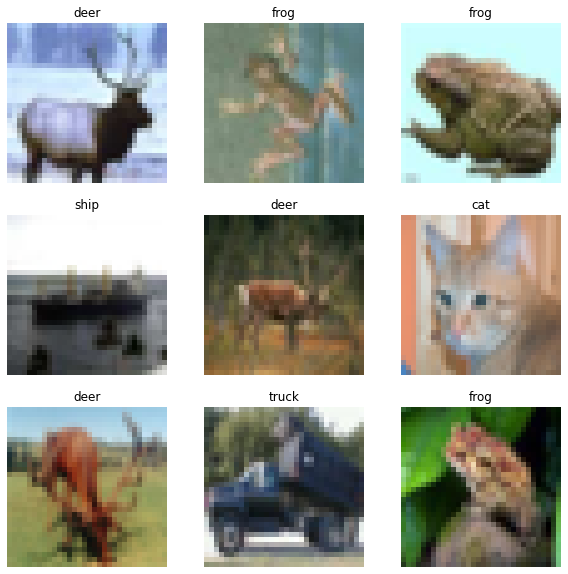

In [6]:
sample = next(iter(train_loader))
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(torch.permute(sample[0][i], (1, 2, 0)))
    plt.axis('off')
    plt.title(classes[sample[1][i].item()])
plt.show()

In [7]:
class BasicBlock(nn.Module):
    mul = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.shortcut = nn.Sequential()

        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.block(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class BottleNeck(nn.Module):
    mul = 4
    def __init__(self, in_channels, out_channels, stride):
        super(BottleNeck, self).__init__()
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * self.mul, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * self.mul)
        )

        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_channels != out_channels * self.mul:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.mul, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.mul)
        )
            
    def forward(self, x):
        out = self.bottleneck(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.maxpool1 = nn.MaxPool2d(3, 2)
        
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(512 * block.mul, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.mul
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [8]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [9]:
lr = 1e-3
epochs = 50

model = ResNet50()
model_name = type(model).__name__
model.to(device)
summary(model, input_size=(3, 32, 32))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4             [-1, 64, 7, 7]           4,096
       BatchNorm2d-5             [-1, 64, 7, 7]             128
              ReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          36,864
       BatchNorm2d-8             [-1, 64, 7, 7]             128
              ReLU-9             [-1, 64, 7, 7]               0
           Conv2d-10            [-1, 256, 7, 7]          16,384
      BatchNorm2d-11            [-1, 256, 7, 7]             512
           Conv2d-12            [-1, 256, 7, 7]          16,384
      BatchNorm2d-13            [-1, 256, 7, 7]             512
       BottleNeck-14            [-1, 25

In [10]:
def train(epoch, model, train_loader, loss_fn, optimizer):
    print(f' Epoch: [{epoch}/{epochs}] - Train')
    model.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
        current_loss = 0.0
        currnet_correct = 0.0

        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        currnet_correct += torch.sum(preds == labels.data)

        if batch_idx % 100 == 0:
            train_loss = current_loss / 100
            train_acc = currnet_correct / 100
            print(f'Current Step: {batch_idx} \tTrain Loss: {train_loss}, Train Accuracy: {train_acc}')
            current_loss = 0.0
            currnet_correct = 0.0
    return train_loss, train_acc

def validation(epoch, model, val_loader, loss_fn):
    print(f' Epoch: [{epoch}/{epochs}] - Validation')
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        val_correct = 0.0
        for val_idx, (val_images, val_labels) in enumerate(val_loader):

            val_images, val_labels = val_images.to(device), val_labels.to(device)
            
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)

            val_loss += loss_fn(val_outputs, val_labels) / val_outputs.shape[0]
            val_correct += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0]

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / len(val_loader)

    print(f'Validation step: Val Loss: {val_epoch_loss}, Val Accuracy: {val_epoch_acc}')
    return val_epoch_loss, val_epoch_acc

In [11]:
log_dir = f"runs/{datetime.now().isoformat(timespec='seconds')}-{model_name}"
model_path = os.path.join(log_dir, 'models')
os.makedirs(model_path, exist_ok=True)

In [12]:
save_point = 10001
path = os.path.join(model_path, 'model.ckpt')

train_result = []
val_result = []

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(epoch, model, train_loader, loss_fn, optimizer)
    val_loss, val_acc = validation(epoch, model, val_loader, loss_fn)

    train_result.append([train_loss, train_acc])
    val_result.append([val_loss, val_acc])

    if val_loss < save_point:
        save_point = val_loss
        save_dir = os.path.dirname(path)
        torch.save(model, os.path.join(save_dir, f'val_loss-{val_loss}-{path.split("/")[-1]}'))
        print('Saved Model!!!')

 Epoch: [1/50] - Train
Current Step: 0 	Train Loss: 0.027352001667022705, Train Accuracy: 0.04999999701976776
Current Step: 100 	Train Loss: 0.018287678956985475, Train Accuracy: 0.2199999988079071
Current Step: 200 	Train Loss: 0.019142907857894898, Train Accuracy: 0.23999999463558197
Current Step: 300 	Train Loss: 0.018197567462921144, Train Accuracy: 0.22999998927116394
Current Step: 400 	Train Loss: 0.016526039838790894, Train Accuracy: 0.23999999463558197
Current Step: 500 	Train Loss: 0.01644112467765808, Train Accuracy: 0.3100000023841858
Current Step: 600 	Train Loss: 0.021186199188232422, Train Accuracy: 0.25999999046325684
Current Step: 700 	Train Loss: 0.017897322177886962, Train Accuracy: 0.25
 Epoch: [1/50] - Validation
Validation step: Val Loss: 0.03633834049105644, Val Accuracy: 0.381526917219162
Saved Model!!!
 Epoch: [2/50] - Train
Current Step: 0 	Train Loss: 0.0202414870262146, Train Accuracy: 0.19999998807907104
Current Step: 100 	Train Loss: 0.020190744400024413, T

In [13]:
test_labels_list = []
test_preds_list = []
test_outputs_list = []

for idx, (test_images, test_labels) in enumerate(test_loader):
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    test_outputs = model(test_images)
    _, test_preds = torch.max(test_outputs, 1)

    final_outs = F.softmax(test_outputs, dim=1)
    test_outputs_list.extend(final_outs)
    test_preds_list.extend(test_preds.detach().cpu().numpy())
    test_labels_list.extend(test_labels.detach().cpu().numpy())

test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f"acc: {np.mean(test_preds_list == test_labels_list) * 100}%")

acc: 77.92%


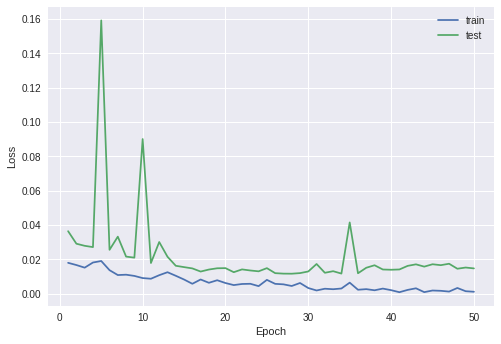

In [14]:
plt.style.use('seaborn')
plt.plot([i for i in range(1, epochs + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(1, epochs + 1)], [i[0] for i in val_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

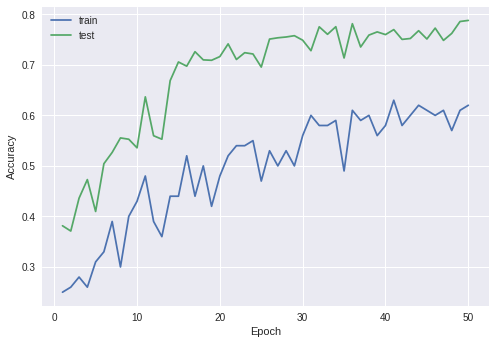

In [15]:
plt.plot([i for i in range(1, epochs + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(1, epochs + 1)], [i[1] for i in val_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()